In [1]:
import time
import argparse
import numpy as np
import scipy.io as sio
from copy import deepcopy
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch import optim
from einops import rearrange
import torch.utils.data as Data
import torch.nn.functional as F
from torchsummary import summary
import torch.backends.cudnn as cudnn


from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler


from caps_vit import Margin_Recon_Loss
from caps_vit import Discriminator, train_gan
from caps_vit import generate_new_samples, deepfool


from data_prepare import mirror_hsi
from data_prepare import choose_train_and_test_number
from data_prepare import choose_train_and_test_proportion
from data_prepare import train_and_test_data, train_and_test_label


from Utils import ActivationOutputData, safe_norm
from Utils import output_metric, plot_confusion_matrix
from Utils import train_epoch, test_epoch, valid_epoch
from Utils import list_to_colormap, classification_map, print_args


from auxiliary_classifier import auxiliary_test_epoch
from auxiliary_classifier import auxiliary_train_epoch
from auxiliary_classifier import auxiliary_valid_epoch
from active_learning import initialize_models, search_confident_samples


%matplotlib inline

In [2]:
parser = argparse.ArgumentParser("Caps-Transformer")
parser.add_argument('--dataset', choices=['Chikusei', 'Pavia', 'KSC', 'HU2013'], default='KSC', help='dataset to use')
parser.add_argument('--flag_test', choices=['test', 'train'], default='train', help='testing mark')
parser.add_argument('--mode', choices=['ViT', 'CAF'], default='CAF', help='mode choice')
parser.add_argument('--gpu_id', default='0', help='GPU id')
parser.add_argument('--seed', type=int, default=0, help='number of seed')
parser.add_argument('--batch_size', type=int, default=30, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=9, help='size of patches')
parser.add_argument('--epoches', type=int, default=200, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=5e-4, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--weight_decay', type=float, default=0.001, help='weight_decay')
parser.add_argument('--train_number', type=int, default=1, help='num_train_per_class')
parser.add_argument('--train_proportion', type=float, default=0.1, help='num_train_per_class')
parser.add_argument('--iterations', type=int, default=5, help='active learning iterations')
args = parser.parse_args(args=[])

In [3]:
# Set the random seeds for torch.random and torch.cuda.random to initialize various parameters of the models and ensure consistency in the 
# DataLoader during each experiment process when generating random mini_batches, to ensure that the experimental results of each run remain 
# the same.


torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
cudnn.deterministic = True
cudnn.benchmark = False

In [4]:
# prepare data
if args.dataset == 'Chikusei':
    data = h5py.File('./dataset/Chikusei.mat', 'r')['chikusei']
    data = np.array(data)
    data = np.transpose(data, (2, 1, 0))
    label = sio.loadmat('./dataset/Chikusei_gt.mat')['GT'][0][0][0]
elif args.dataset == 'HU2013':
    data = sio.loadmat('./dataset/Houston.mat')['Houston']
    label = sio.loadmat('./dataset/Houston_gt.mat')['Houston_gt']
elif args.dataset == 'Pavia':
    data = sio.loadmat('./dataset/PaviaU.mat')['paviaU']
    label = sio.loadmat('./dataset/PaviaU_gt.mat')['paviaU_gt']
elif args.dataset == 'KSC':
    data = sio.loadmat('./dataset/KSC.mat')['KSC']
    label = sio.loadmat('./dataset/KSC_gt.mat')['KSC_gt']
else:
    raise ValueError("Unknown dataset")
    
num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 13


In [5]:
shapeor = data.shape
data = data.reshape(np.prod(data.shape[:2]), np.prod(data.shape[2:]))

std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(data)
data = std_data.reshape(shapeor)

In [6]:
total_pos_train, total_pos_test, total_pos_true, number_train, number_test, number_true = \
choose_train_and_test_number(label, args.train_number, seed=args.seed)

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=512, width=614, band=176


In [7]:
mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

x_train, x_test, x_true = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, 
                                              total_pos_true, patch_size=args.patch_size)

y_train, y_test, y_true = train_and_test_label(number_train, number_test, number_true, num_classes)

**************************************************
patch_size is : 9
mirror_data shape : [520, 622, 176]
**************************************************
x_train shape = (13, 9, 9, 176), type = float64
x_test  shape = (5198, 9, 9, 176), type = float64
x_true  shape = (5211, 9, 9, 176), type = float64
**************************************************
y_train: shape = (13,), type = int64
y_test: shape = (5198,), type = int64
y_true: shape = (5211,), type = int64
**************************************************


In [8]:
# load data
x_train_ask = torch.from_numpy(x_train).unsqueeze(1).type(torch.FloatTensor)  # (13, 1, 7, 7, 176)
x_train_cap = torch.from_numpy(x_train.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (13, 176, 7, 7)
print(x_train_ask.shape, x_train_cap.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
Train_Label_Ask = Data.TensorDataset(x_train_ask, y_train)
Train_Label_Cap = Data.TensorDataset(x_train_cap, y_train)
train_loader_ask = Data.DataLoader(Train_Label_Ask, batch_size=args.batch_size, shuffle=True)
train_loader_cap = Data.DataLoader(Train_Label_Cap, batch_size=args.batch_size, shuffle=True)


x_test_ask = torch.from_numpy(x_test).unsqueeze(1).type(torch.FloatTensor)  # (5198, 1, 7, 7, 176)
x_test_cap = torch.from_numpy(x_test.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5198, 176, 7, 7)
print(x_test_ask.shape, x_test_cap.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
Test_Label_Ask = Data.TensorDataset(x_test_ask, y_test)
Test_Label_Cap = Data.TensorDataset(x_test_cap, y_test)
test_loader_ask = Data.DataLoader(Test_Label_Ask, batch_size=args.batch_size, shuffle=True)
test_loader_cap = Data.DataLoader(Test_Label_Cap, batch_size=args.batch_size, shuffle=True)


x_true_ask = torch.from_numpy(x_true).unsqueeze(1).type(torch.FloatTensor)  # (5211, 1, 7, 7, 176)
x_true_cap = torch.from_numpy(x_true.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5211, 176, 7, 7)
print(x_true_ask.shape, x_true_cap.shape)
y_true = torch.from_numpy(y_true).type(torch.LongTensor)
True_Label_Ask = Data.TensorDataset(x_true_ask, y_true)
True_Label_Cap = Data.TensorDataset(x_true_cap, y_true)
true_loader_ask = Data.DataLoader(True_Label_Ask, batch_size=100, shuffle=False)
true_loader_cap = Data.DataLoader(True_Label_Cap, batch_size=100, shuffle=False)

candidate_loader = deepcopy(test_loader_cap)

torch.Size([13, 1, 9, 9, 176]) torch.Size([13, 176, 9, 9])
torch.Size([5198, 1, 9, 9, 176]) torch.Size([5198, 176, 9, 9])
torch.Size([5211, 1, 9, 9, 176]) torch.Size([5211, 176, 9, 9])


## Active Learning

In [9]:
for i in range(args.iterations):
    model_cap, model_ask, model_glom = initialize_models(band, args.patch_size, num_classes)
    # criterion
    criterion_cap = Margin_Recon_Loss()
    criterion_ask = nn.CrossEntropyLoss()
    criterion_glom = nn.CrossEntropyLoss()
    # optimizer
    optimizer_cap = optim.Adam(model_cap.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
    optimizer_ask = optim.Adam(model_ask.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
    optimizer_glom = optim.Adam(model_glom.parameters(), lr=1e-3)
    # learning scheduler
    scheduler_cap = optim.lr_scheduler.ExponentialLR(optimizer_cap, gamma=args.gamma)
    scheduler_ask = optim.lr_scheduler.ExponentialLR(optimizer_ask, gamma=args.gamma)
    scheduler_glom = optim.lr_scheduler.ExponentialLR(optimizer_glom, gamma=args.gamma)

    print("****************************************************************")
    print('Training S3KAIResNet')
    # train model
    model_ask.train()
    tic = time.time()
    for epoch in range(args.epoches):
        # The calculation is based on the moving average accuracy.
        train_acc, train_obj, tar_train, pre_train = auxiliary_train_epoch(model_ask, train_loader_ask, criterion_ask, optimizer_ask)
        OA_trian, AA_mean_train, Kappa_train, AA_train = output_metric(tar_train, pre_train)
        print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}".format(epoch+1, train_obj, train_acc))
        scheduler_ask.step()

    toc = time.time()
    torch.save(model_ask.state_dict(), './models/A2S2KResNet_{}.pt'.format(i+1))
    print("Running Time: {:.2f}".format(toc-tic))
    print("****************************************************************")

    print('Training CapsViT')
    # train model
    model_cap.train()
    tic = time.time()
    for epoch in range(args.epoches):
        # The calculation is based on the moving average accuracy.
        train_acc, train_obj, tar_train, pre_train = train_epoch(model_cap, train_loader_cap, criterion_cap, optimizer_cap)
        OA_trian, AA_mean_train, Kappa_train, AA_train = output_metric(tar_train, pre_train)
        print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}".format(epoch+1, train_obj, train_acc))
        scheduler_cap.step()

    toc = time.time()
    torch.save(model_cap.state_dict(), './models/CapsViT_{}.pt'.format(i+1))
    print("Running Time: {:.2f}".format(toc-tic))
    print("****************************************************************")
    
    print('Training CapsGLOM')
    # train model
    model_glom.train()
    tic = time.time()
    for epoch in range(args.epoches):
        # The calculation is based on the moving average accuracy.
        train_acc, train_obj, tar_train, pre_train = auxiliary_train_epoch(model_glom, train_loader_cap, criterion_glom, optimizer_glom)
        OA_trian, AA_mean_train, Kappa_train, AA_train = output_metric(tar_train, pre_train)
        print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}".format(epoch+1, train_obj, train_acc))
        scheduler_glom.step()

    toc = time.time()
    torch.save(model_glom.state_dict(), './models/CapsGLOM_{}.pt'.format(i+1))
    print("Running Time: {:.2f}".format(toc-tic))
    print("****************************************************************")

    if i < args.iterations - 1:
        high_confidence_samples, high_confidence_labels, candidate_loader = \
        search_confident_samples(model_cap, model_ask, model_glom, candidate_loader)

        x_train_ask = torch.cat([x_train_ask, rearrange(high_confidence_samples, 'b c h w -> b h w c').unsqueeze(1)])
        x_train_cap = torch.cat([x_train_cap, high_confidence_samples])
        print(x_train_ask.shape, x_train_cap.shape)
        y_train = torch.cat([y_train, high_confidence_labels])

        Train_Label_Cap = Data.TensorDataset(x_train_cap, y_train)
        Train_Label_Ask = Data.TensorDataset(x_train_ask, y_train)
        train_loader_cap = Data.DataLoader(Train_Label_Cap, batch_size=args.batch_size, shuffle=True)
        train_loader_ask = Data.DataLoader(Train_Label_Ask, batch_size=args.batch_size, shuffle=True)

****************************************************************
Training S3KAIResNet
Epoch: 001 train_loss: 2.5719 train_acc: 7.6923
Epoch: 002 train_loss: 2.1781 train_acc: 30.7692
Epoch: 003 train_loss: 1.9305 train_acc: 69.2308
Epoch: 004 train_loss: 1.7412 train_acc: 76.9231
Epoch: 005 train_loss: 1.6053 train_acc: 69.2308
Epoch: 006 train_loss: 1.5066 train_acc: 69.2308
Epoch: 007 train_loss: 1.4151 train_acc: 76.9231
Epoch: 008 train_loss: 1.3351 train_acc: 76.9231
Epoch: 009 train_loss: 1.2639 train_acc: 84.6154
Epoch: 010 train_loss: 1.2020 train_acc: 92.3077
Epoch: 011 train_loss: 1.1504 train_acc: 92.3077
Epoch: 012 train_loss: 1.1051 train_acc: 92.3077
Epoch: 013 train_loss: 1.0606 train_acc: 92.3077
Epoch: 014 train_loss: 1.0193 train_acc: 92.3077
Epoch: 015 train_loss: 0.9843 train_acc: 92.3077
Epoch: 016 train_loss: 0.9509 train_acc: 92.3077
Epoch: 017 train_loss: 0.9198 train_acc: 92.3077
Epoch: 018 train_loss: 0.8900 train_acc: 100.0000
Epoch: 019 train_loss: 0.8605 tr

****************************************************************
Testing S3KAIResNet


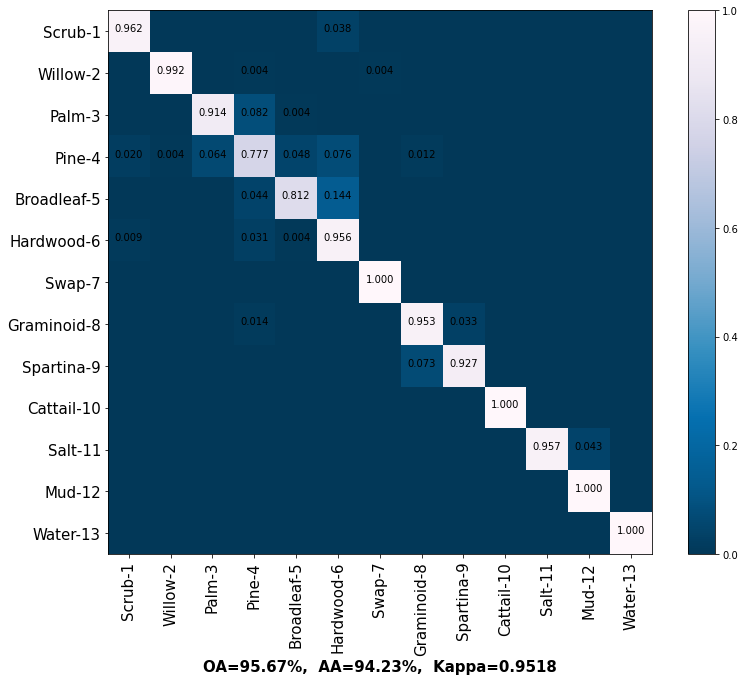

****************************************************************
S3KAIResNet Final Result:
OA: 95.67% | AA: 94.23% | Kappa: 0.9518
[0.96184211 0.99173554 0.91372549 0.77689243 0.8125     0.95614035
 1.         0.95348837 0.92678227 1.         0.9569378  1.
 1.        ]
****************************************************************
****************************************************************
Testing CapsViT


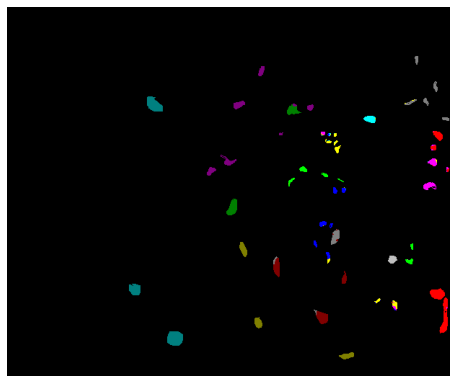

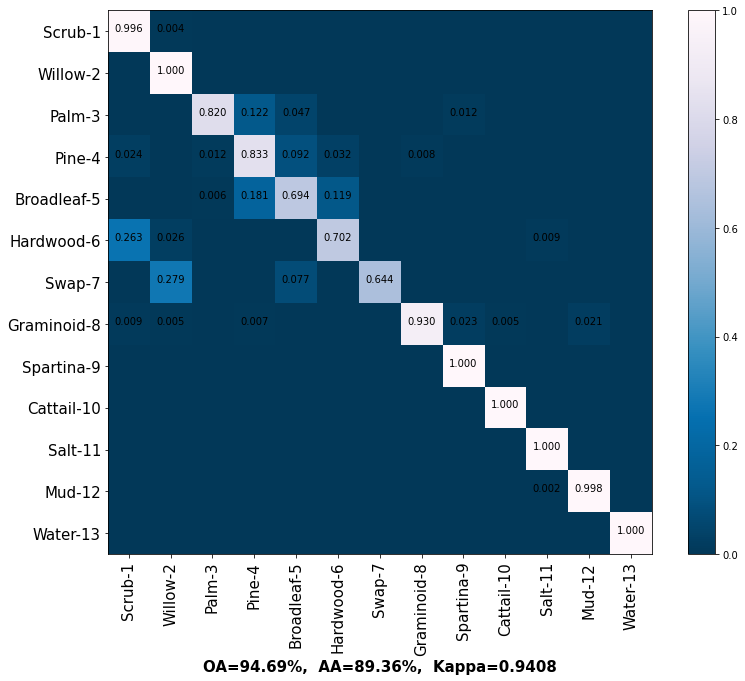

****************************************************************
CapsViT Final Result:
OA: 94.69% | AA: 89.36% | Kappa: 0.9408
[0.99605263 1.         0.81960784 0.83266932 0.69375    0.70175439
 0.64423077 0.93023256 1.         1.         1.         0.99800797
 1.        ]
****************************************************************
****************************************************************
Testing CapsGLOM


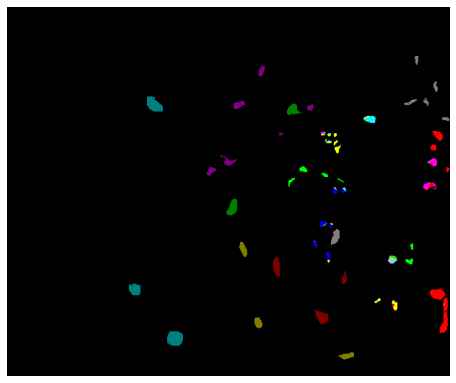

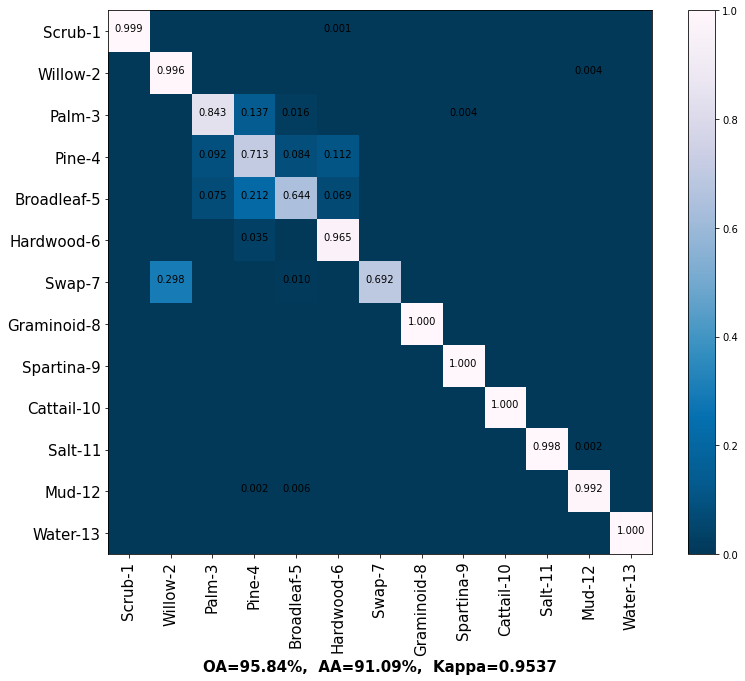

****************************************************************
CapsGLOM Final Result:
OA: 95.84% | AA: 91.09% | Kappa: 0.9537
[0.99868421 0.99586777 0.84313725 0.71314741 0.64375    0.96491228
 0.69230769 1.         1.         1.         0.99760766 0.99203187
 1.        ]
****************************************************************


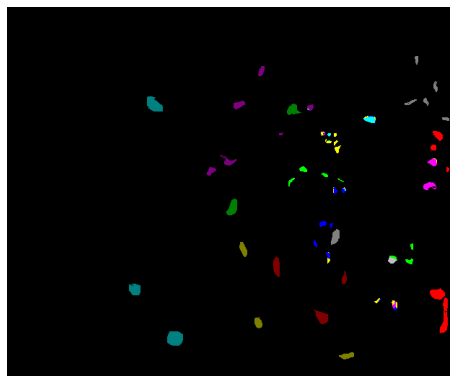

In [10]:
model_cap, model_ask, model_glom = initialize_models(band, args.patch_size, num_classes)

model_cap.load_state_dict(torch.load('./models/CapsViT_{}.pt'.format(args.iterations)))
model_ask.load_state_dict(torch.load('./models/A2S2KResNet_{}.pt'.format(args.iterations)))
model_glom.load_state_dict(torch.load('./models/CapsGLOM_{}.pt'.format(args.iterations)))

print("****************************************************************")
print('Testing S3KAIResNet')
model_ask.eval()
tar_test, pre_test = auxiliary_test_epoch(model_ask, test_loader_ask)  # Collect all real and predicted tags(np.array)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)

# output classification maps
pre_u = auxiliary_valid_epoch(model_ask, true_loader_ask)
prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(total_pos_true.shape[0]):
    prediction_matrix[total_pos_true[i, 0], total_pos_true[i, 1]] = pre_u[i] + 1
cm = confusion_matrix(tar_test, pre_test)
plot_confusion_matrix(args.dataset, cm, path='./Confusion_Map_A2S2KResNet.pdf')

predict_map = list_to_colormap(prediction_matrix.ravel())
predict_map = np.reshape(predict_map, (height, width, 3))
classification_map(predict_map, './Predict_Map_A2S2KResNet.pdf')


print("****************************************************************")
print("S3KAIResNet Final Result:")
print("OA: {:.2f}% | AA: {:.2f}% | Kappa: {:.4f}".format(OA_test * 100., AA_mean_test * 100., Kappa_test))
print(AA_test)
print("****************************************************************")

print("****************************************************************")
print('Testing CapsViT')
model_cap.eval()
tar_test, pre_test = test_epoch(model_cap, test_loader_cap)  # Collect all real and predicted tags(np.array)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)

# output classification maps
pre_u = valid_epoch(model_cap, true_loader_cap)
prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(total_pos_true.shape[0]):
    prediction_matrix[total_pos_true[i, 0], total_pos_true[i, 1]] = pre_u[i] + 1
cm = confusion_matrix(tar_test, pre_test)
plot_confusion_matrix(args.dataset, cm, path='./Confusion_Map_CapsViT.pdf')

predict_map = list_to_colormap(prediction_matrix.ravel())
predict_map = np.reshape(predict_map, (height, width, 3))
classification_map(predict_map, './Predict_Map_CapsViT.pdf')


print("****************************************************************")
print("CapsViT Final Result:")
print("OA: {:.2f}% | AA: {:.2f}% | Kappa: {:.4f}".format(OA_test * 100., AA_mean_test * 100., Kappa_test))
print(AA_test)
print("****************************************************************")

print("****************************************************************")
print('Testing CapsGLOM')
model_glom.eval()
tar_test, pre_test = auxiliary_test_epoch(model_glom, test_loader_cap)  # Collect all real and predicted tags(np.array)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)

# output classification maps
pre_u = auxiliary_valid_epoch(model_glom, true_loader_cap)
prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(total_pos_true.shape[0]):
    prediction_matrix[total_pos_true[i, 0], total_pos_true[i, 1]] = pre_u[i] + 1
cm = confusion_matrix(tar_test, pre_test)
plot_confusion_matrix(args.dataset, cm, path='./Confusion_Map_MobileViT.pdf')

predict_map = list_to_colormap(prediction_matrix.ravel())
predict_map = np.reshape(predict_map, (height, width, 3))
classification_map(predict_map, './Predict_Map_CapsGLOM.pdf')

print("****************************************************************")
print("CapsGLOM Final Result:")
print("OA: {:.2f}% | AA: {:.2f}% | Kappa: {:.4f}".format(OA_test * 100., AA_mean_test * 100., Kappa_test))
print(AA_test)
print("****************************************************************")